# Delineate basins 1-by-1
This is a working script used to delineate basins using the MERIT Hydro data (DEM, flow direction, basin discretization). CAMELS-US and RHBN metadata about station locations do not always lead to accurate basin delineation. In this script we go through the basins one by one, so that we can manually modify the outlet location in the CAMELS-spat metadata file for basins for which the original station or outlet location is not a good fit with the MERIT DEM. This also lets us add extra notes about the confidence we have in this manually moved outlet and therefore the resulting basin outline. 

In [1]:
import sys
import shutil
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# MERIT Hydro data
merit_path = cs.read_from_config(config_file, 'merit_path')
merit_acc = Path(data_path) / merit_path / 'flow_accumulation_grid' / 'merit_hydro_acc.tif'
merit_dir = Path(data_path) / merit_path / 'flow_direction_grid' / 'merit_hydro_dir.tif'
merit_bas = Path(data_path) / merit_path / 'shapes' / 'basins' / 'cat_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1_hillslopes_pfaf_7_8_clean_fixed.shp'
merit_riv = Path(data_path) / merit_path / 'shapes' / 'rivers' / 'riv_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# CRS to use for area calculations and overlap
crs = cs.read_from_config(config_file, 'equal_area_crs')

### Data loading

In [20]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [7]:
# Shapefiles
basins_shp = gpd.read_file(merit_bas)
rivers_shp = gpd.read_file(merit_riv)

In [8]:
# Fix up the missing hillslopes
# We are missing out on a single coastal hillslope in northern canada. Chances are we can complete the procedure anyway
arctic_hill_files = [Path(data_path) / merit_path / 'shapes' / 'basins' / 'hillslope_84_clean_fixed.shp',
                     Path(data_path) / merit_path / 'shapes' / 'basins' / 'hillslope_85_clean_fixed.shp']

arctic_hill_84 = gpd.read_file(arctic_hill_files[0])
arctic_hill_85 = gpd.read_file(arctic_hill_files[1])

basins_shp = pd.concat([basins_shp,arctic_hill_84,arctic_hill_85])

### Delineation

In [9]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [10]:
# Make sure we know the correct metadata columns
c_area = np.where(cs_meta.columns == 'Basin_area_km2')[0][0]
c_over = np.where(cs_meta.columns == 'Ref_and_new_shape_fractional_overlap')[0][0]

assert (cs_meta.columns[c_area] == 'Basin_area_km2') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_over] == 'Ref_and_new_shape_fractional_overlap')

In [11]:
def delineation_loop(i,plot=False):
    
    '''Delineates basin for station at index i in the CAMELS-spat metadata file'''
    
    # Input:
    # i - index in CAMELS-spat metadata file to process
    
    # 1. Prepare file paths and names
    # --------------------------------------------------------------------------------------
    basin_id, shp_lump_path, shp_dist_path, ref_path, plot_path = \
                                        cs.prepare_delineation_outputs(cs_meta, i, Path(data_path)/cs_basin_folder)
    print('Now running basin {}. {}'.format(i,basin_id))
    
    # 2. Get the station or outlet location
    # --------------------------------------------------------------------------------------
    lat,lon = cs.read_delineation_coords(cs_meta,i)
    #print('!!! Running with fixed lat/lon coordinates !!!'); lon,lat = -90.81951,42.72049
    
    # 3. Delineate the basin
    # --------------------------------------------------------------------------------------
    # 3a. Subset the Geotiffs for quicker processing
    subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
    temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                                    str(merit_acc), 
                                                    str(merit_dir),
                                                    temp_dir = tmp_dir)
    grid,acc,fdir = cs.load_tifs_with_pysheds(str(temp_acc),str(temp_dir)) 
        
    # 3b. Basin extraction
    # Ignore future warnings for this part of the code to avoid FutureWarning screen spam by Shapely and Pandas
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        # Extract the full basin with pysheds
        lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path) # Saves file as part of function
        lump_basin = cs.add_area_to_shape(lump_basin, column='unitarea', crs=crs)
        
        # Extract the MERIT Hydro basins and river network
        dist_basin, dist_river = cs.subset_merit_hydro_to_basin(basins_shp,rivers_shp,lump_basin,shp_dist_path,
                                                                lat,lon,crs=crs) # Ditto
    
    # 4. Delineation checks
    # --------------------------------------------------------------------------------------
    # 4a. Assert shape validity
    if not all(lump_basin.is_valid): print('ERROR: Lumped shape not valid') # assert() throws SyntaxWarning over .is_valid
    if not all(dist_basin.is_valid): print('ERROR: Distributed shape not valid')
        
    # 4b. Get areas and overlap
    area_lump = (lump_basin.to_crs('ESRI:102008').area / 10**6)[0] # [km^2]
    area_dist = dist_basin['unitarea'].sum() # [km^2]
    overlap_lump = cs.calculate_basin_and_reference_overlap(lump_basin, ref_path, crs=crs) # Returns 'n/a' if no reference shape
    overlap_dist = cs.calculate_basin_and_reference_overlap(dist_basin, ref_path, crs=crs) # Should be identical to lumped
    
    # 4c. Visual assessment of outcomes
    ref_areas = cs.get_reference_areas(cs_meta,i) # [km^2] 
    stats = cs.prepare_plotting_stats(ref_areas,area_lump,area_dist,overlap_lump,overlap_dist) 
    #if plot:
    #    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, stats, plot_path)
    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, stats, \
                                   plot_path, to_screen=plot)
    
    # 4d. Update metadata file
    cs_meta.iat[i,c_area] = area_dist
    cs_meta.iat[i,c_over] = overlap_dist
    
    # 5 Clean up - no guarantee this will do anything, but who knows
    del temp_acc, temp_dir, grid, acc, fdir, lump_basin, dist_basin, dist_river
    
    return

#### Manual runs

In [24]:
i = 1328

In [25]:
run_this = i
cs_meta.iloc[run_this].Station_id

'05412500'

Now running basin 1328. USA_05412500


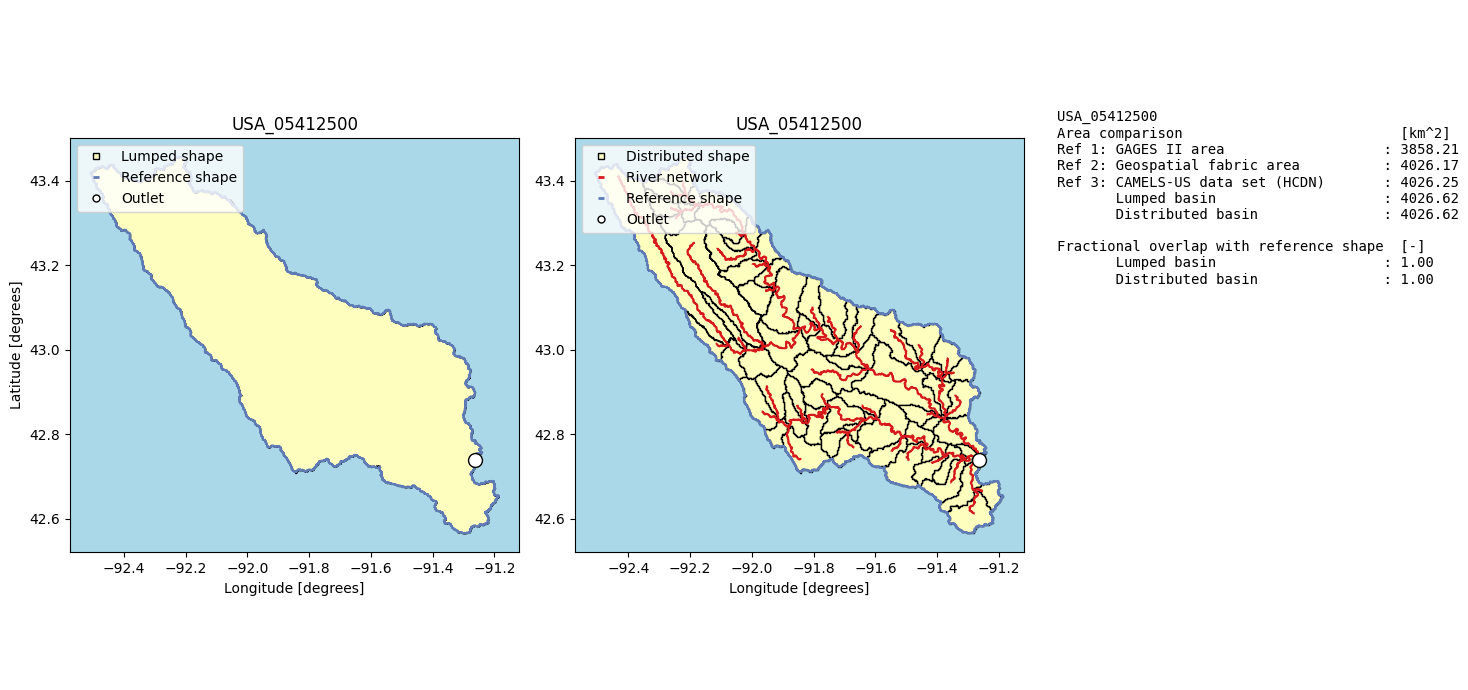

In [26]:
delineation_loop(run_this, plot=True)

#### End manual runs

In [10]:
for i,_ in cs_meta.iterrows():
#for i in range(289,len(cs_meta)):
#for i in range(0,289):
    delineation_loop(i)

Now running basin 0. CAN_01AD002
Now running basin 1. CAN_01AD003
Now running basin 2. CAN_01AE001
Now running basin 3. CAN_01AF007
Now running basin 4. CAN_01AF009
Now running basin 5. CAN_01AJ003
Now running basin 6. CAN_01AJ004
Now running basin 7. CAN_01AJ010
Now running basin 8. CAN_01AK001
Now running basin 9. CAN_01AK006


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 10. CAN_01AK007
Now running basin 11. CAN_01AL002
Now running basin 12. CAN_01AL004


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 13. CAN_01AM001
Now running basin 14. CAN_01AN002
Now running basin 15. CAN_01AP002
Now running basin 16. CAN_01AP004
Now running basin 17. CAN_01AP006
Now running basin 18. CAN_01AQ001
Now running basin 19. CAN_01BC001
Now running basin 20. CAN_01BD008
Now running basin 21. CAN_01BE001
Now running basin 22. CAN_01BG005
Now running basin 23. CAN_01BG008
Now running basin 24. CAN_01BG009
Now running basin 25. CAN_01BH005
Now running basin 26. CAN_01BH010
Now running basin 27. CAN_01BJ003
Now running basin 28. CAN_01BJ007
Now running basin 29. CAN_01BJ010
Now running basin 30. CAN_01BJ012
Now running basin 31. CAN_01BL002
Now running basin 32. CAN_01BL003
Now running basin 33. CAN_01BO001
Now running basin 34. CAN_01BP001
Now running basin 35. CAN_01BP002
Now running basin 36. CAN_01BQ001
Now running basin 37. CAN_01BS001
Now running basin 38. CAN_01BU002
Now running basin 39. CAN_01BU009


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 40. CAN_01BV004
Now running basin 41. CAN_01BV006
Now running basin 42. CAN_01CA003
Now running basin 43. CAN_01CC005
Now running basin 44. CAN_01CD005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 45. CAN_01DG003
Now running basin 46. CAN_01DJ005
Now running basin 47. CAN_01DL001
Now running basin 48. CAN_01DP004
Now running basin 49. CAN_01DR001
Now running basin 50. CAN_01EC001
Now running basin 51. CAN_01ED005
Now running basin 52. CAN_01ED007
Now running basin 53. CAN_01EE005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 54. CAN_01EF001
Now running basin 55. CAN_01EO001
Now running basin 56. CAN_01FA001
Now running basin 57. CAN_01FB001
Now running basin 58. CAN_01FB003
Now running basin 59. CAN_01FJ002


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 60. CAN_02AB008
Now running basin 61. CAN_02AB014
Now running basin 62. CAN_02AB017
Now running basin 63. CAN_02AB021
Now running basin 64. CAN_02AC001
Now running basin 65. CAN_02AC002
Now running basin 66. CAN_02AD010
Now running basin 67. CAN_02AE001
Now running basin 68. CAN_02BA003
Now running basin 69. CAN_02BA005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 70. CAN_02BB003
Now running basin 71. CAN_02BF001
Now running basin 72. CAN_02BF002
Now running basin 73. CAN_02BF004
Now running basin 74. CAN_02BF005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 75. CAN_02BF006


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 76. CAN_02BF007


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 77. CAN_02BF008


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 78. CAN_02BF009


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 79. CAN_02BF012


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 80. CAN_02BF013


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 81. CAN_02CA002
Now running basin 82. CAN_02CB003
Now running basin 83. CAN_02CF007
Now running basin 84. CAN_02CF008
Now running basin 85. CAN_02CF011
Now running basin 86. CAN_02CG003


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 87. CAN_02DB007
Now running basin 88. CAN_02DC012
Now running basin 89. CAN_02DD012
Now running basin 90. CAN_02DD013
Now running basin 91. CAN_02DD015
Now running basin 92. CAN_02EA005
Now running basin 93. CAN_02EA010
Now running basin 94. CAN_02EB014
Now running basin 95. CAN_02EC002
Now running basin 96. CAN_02EC010
Now running basin 97. CAN_02EC011
Now running basin 98. CAN_02EC018
Now running basin 99. CAN_02ED003
Now running basin 100. CAN_02ED007
Now running basin 101. CAN_02ED013
Now running basin 102. CAN_02ED014
Now running basin 103. CAN_02ED015
Now running basin 104. CAN_02ED017
Now running basin 105. CAN_02ED024
Now running basin 106. CAN_02ED026
Now running basin 107. CAN_02ED101
Now running basin 108. CAN_02ED102
Now running basin 109. CAN_02FA002
Now running basin 110. CAN_02FA004
Now running basin 111. CAN_02FB007
Now running basin 112. CAN_02FB010
Now running basin 113. CAN_02FC011
Now running basin 114. CAN_02FC016
Now running basin 115. CAN_02FC01

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 131. CAN_02GB007
Now running basin 132. CAN_02GC002
Now running basin 133. CAN_02GC010
Now running basin 134. CAN_02GC018
Now running basin 135. CAN_02GC021
Now running basin 136. CAN_02GC029
Now running basin 137. CAN_02GC030
Now running basin 138. CAN_02GC031
Now running basin 139. CAN_02GD004
Now running basin 140. CAN_02GD010
Now running basin 141. CAN_02GD019
Now running basin 142. CAN_02GD021
Now running basin 143. CAN_02GE007
Now running basin 144. CAN_02GG002
Now running basin 145. CAN_02GG003
Now running basin 146. CAN_02GG005
Now running basin 147. CAN_02GG006
Now running basin 148. CAN_02GG009
Now running basin 149. CAN_02GH002
Now running basin 150. CAN_02GH003
Now running basin 151. CAN_02HA006
Now running basin 152. CAN_02HA020
Now running basin 153. CAN_02HB012
Now running basin 154. CAN_02HB022
Now running basin 155. CAN_02HB023
Now running basin 156. CAN_02HC019
Now running basin 157. CAN_02HC023
Now running basin 158. CAN_02HC025
Now running basin 15

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 206. CAN_02PC019
Now running basin 207. CAN_02PD002
Now running basin 208. CAN_02PD004
Now running basin 209. CAN_02PD012


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 210. CAN_02PD013


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 211. CAN_02PD014


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 212. CAN_02PD015


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 213. CAN_02PE014
Now running basin 214. CAN_02PG006
Now running basin 215. CAN_02PG022
Now running basin 216. CAN_02PJ007
Now running basin 217. CAN_02PJ030
Now running basin 218. CAN_02PL005
Now running basin 219. CAN_02QA002
Now running basin 220. CAN_02QC009
Now running basin 221. CAN_02RC011
Now running basin 222. CAN_02RD003
Now running basin 223. CAN_02RF001
Now running basin 224. CAN_02RF009
Now running basin 225. CAN_02RG005
Now running basin 226. CAN_02RH027
Now running basin 227. CAN_02RH035
Now running basin 228. CAN_02RH045
Now running basin 229. CAN_02UA003
Now running basin 230. CAN_02UC002
Now running basin 231. CAN_02VB004
Now running basin 232. CAN_02WB003
Now running basin 233. CAN_02XA003
Now running basin 234. CAN_02XC001
Now running basin 235. CAN_02YA002


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 236. CAN_02YC001
Now running basin 237. CAN_02YD002
Now running basin 238. CAN_02YE001
Now running basin 239. CAN_02YG001
Now running basin 240. CAN_02YJ001
Now running basin 241. CAN_02YK002
Now running basin 242. CAN_02YK005
Now running basin 243. CAN_02YK008


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 244. CAN_02YL001
Now running basin 245. CAN_02YL004
Now running basin 246. CAN_02YL005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 247. CAN_02YL008
Now running basin 248. CAN_02YL011


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 249. CAN_02YM003
Now running basin 250. CAN_02YM004
Now running basin 251. CAN_02YN002
Now running basin 252. CAN_02YO006
Now running basin 253. CAN_02YO008
Now running basin 254. CAN_02YO012
Now running basin 255. CAN_02YQ001
Now running basin 256. CAN_02YQ005
Now running basin 257. CAN_02YR001
Now running basin 258. CAN_02YR003
Now running basin 259. CAN_02YS003
Now running basin 260. CAN_02YS005
Now running basin 261. CAN_02YS006
Now running basin 262. CAN_02ZA002
Now running basin 263. CAN_02ZB001
Now running basin 264. CAN_02ZC002
Now running basin 265. CAN_02ZD002
Now running basin 266. CAN_02ZE004
Now running basin 267. CAN_02ZF001
Now running basin 268. CAN_02ZG001


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 269. CAN_02ZG003
Now running basin 270. CAN_02ZG004
Now running basin 271. CAN_02ZH001
Now running basin 272. CAN_02ZH002
Now running basin 273. CAN_02ZJ001
Now running basin 274. CAN_02ZJ002
Now running basin 275. CAN_02ZJ003
Now running basin 276. CAN_02ZK001
Now running basin 277. CAN_02ZK002
Now running basin 278. CAN_02ZK003
Now running basin 279. CAN_02ZK004
Now running basin 280. CAN_02ZL004
Now running basin 281. CAN_02ZL005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 282. CAN_02ZM006


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 283. CAN_02ZM009
Now running basin 284. CAN_02ZM016


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 285. CAN_02ZN002


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 286. CAN_03AB002
Now running basin 287. CAN_03AC004
Now running basin 288. CAN_03BD002
Now running basin 289. CAN_03BF001
Now running basin 290. CAN_03ED001
Now running basin 291. CAN_03FA003
Now running basin 292. CAN_03KC004
Now running basin 293. CAN_03MB002
Now running basin 294. CAN_03MD001
Now running basin 295. CAN_03NF001
Now running basin 296. CAN_03OC003
Now running basin 297. CAN_03OE010
Now running basin 298. CAN_03QC001
Now running basin 299. CAN_03QC002
Now running basin 300. CAN_04AA004
Now running basin 301. CAN_04AB001
Now running basin 302. CAN_04AD002
Now running basin 303. CAN_04CA002
Now running basin 304. CAN_04CA003
Now running basin 305. CAN_04CB001
Now running basin 306. CAN_04DA001
Now running basin 307. CAN_04DB001
Now running basin 308. CAN_04DC001
Now running basin 309. CAN_04DC002
Now running basin 310. CAN_04EA001
Now running basin 311. CAN_04FA001
Now running basin 312. CAN_04FA003
Now running basin 313. CAN_04FB001
Now running basin 31

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 388. CAN_05DB002
Now running basin 389. CAN_05DB005
Now running basin 390. CAN_05DB006
Now running basin 391. CAN_05DC006
Now running basin 392. CAN_05DC011
Now running basin 393. CAN_05DC012
Now running basin 394. CAN_05DD004
Now running basin 395. CAN_05DD007
Now running basin 396. CAN_05DD009
Now running basin 397. CAN_05DE007
Now running basin 398. CAN_05DF003
Now running basin 399. CAN_05DF004
Now running basin 400. CAN_05DF006
Now running basin 401. CAN_05DF007
Now running basin 402. CAN_05EA001
Now running basin 403. CAN_05EA002
Now running basin 404. CAN_05EA005
Now running basin 405. CAN_05EA010
Now running basin 406. CAN_05EB902
Now running basin 407. CAN_05EC002
Now running basin 408. CAN_05EC005
Now running basin 409. CAN_05ED002
Now running basin 410. CAN_05EE005
Now running basin 411. CAN_05EE006


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 412. CAN_05EE009
Now running basin 413. CAN_05EF004
Now running basin 414. CAN_05EF005
Now running basin 415. CAN_05EF006
Now running basin 416. CAN_05EG004
Now running basin 417. CAN_05FA001
Now running basin 418. CAN_05FA012
Now running basin 419. CAN_05FA014
Now running basin 420. CAN_05FA024
Now running basin 421. CAN_05FB002
Now running basin 422. CAN_05FC002
Now running basin 423. CAN_05FC004
Now running basin 424. CAN_05FC007
Now running basin 425. CAN_05FE002
Now running basin 426. CAN_05FF003
Now running basin 427. CAN_05GA008
Now running basin 428. CAN_05GA010
Now running basin 429. CAN_05GA012
Now running basin 430. CAN_05GB004
Now running basin 431. CAN_05GC007
Now running basin 432. CAN_05GD002
Now running basin 433. CAN_05GF001
Now running basin 434. CAN_05GF002
Now running basin 435. CAN_05GG010
Now running basin 436. CAN_05HA015
Now running basin 437. CAN_05HD036
Now running basin 438. CAN_05HE001
Now running basin 439. CAN_05HG021


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 440. CAN_05HH002
Now running basin 441. CAN_05HH003
Now running basin 442. CAN_05JA003
Now running basin 443. CAN_05JB004
Now running basin 444. CAN_05JB007
Now running basin 445. CAN_05JC004
Now running basin 446. CAN_05JC007
Now running basin 447. CAN_05JF011
Now running basin 448. CAN_05JF014
Now running basin 449. CAN_05JG001
Now running basin 450. CAN_05JG013
Now running basin 451. CAN_05JH005
Now running basin 452. CAN_05JJ009
Now running basin 453. CAN_05JK008
Now running basin 454. CAN_05JM010
Now running basin 455. CAN_05KB003
Now running basin 456. CAN_05KB006
Now running basin 457. CAN_05KB011
Now running basin 458. CAN_05KC001
Now running basin 459. CAN_05KE005
Now running basin 460. CAN_05KE007
Now running basin 461. CAN_05KE010
Now running basin 462. CAN_05KF001
Now running basin 463. CAN_05KG007
Now running basin 464. CAN_05KH007
Now running basin 465. CAN_05KJ014
Now running basin 466. CAN_05LA003
Now running basin 467. CAN_05LB004
Now running basin 46

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 489. CAN_05MA020
Now running basin 490. CAN_05MA021
Now running basin 491. CAN_05MA025
Now running basin 492. CAN_05MC001
Now running basin 493. CAN_05MC002
Now running basin 494. CAN_05MC003
Now running basin 495. CAN_05MD005
Now running basin 496. CAN_05MD010
Now running basin 497. CAN_05ME003
Now running basin 498. CAN_05ME005
Now running basin 499. CAN_05ME007
Now running basin 500. CAN_05MF001
Now running basin 501. CAN_05MF008
Now running basin 502. CAN_05MG001
Now running basin 503. CAN_05MG003
Now running basin 504. CAN_05MH006
Now running basin 505. CAN_05MH007
Now running basin 506. CAN_05MH008
Now running basin 507. CAN_05NB033
Now running basin 508. CAN_05NB035
Now running basin 509. CAN_05ND011
Now running basin 510. CAN_05NE003
Now running basin 511. CAN_05NF002
Now running basin 512. CAN_05NF006
Now running basin 513. CAN_05NF008
Now running basin 514. CAN_05NF010
Now running basin 515. CAN_05NG010
Now running basin 516. CAN_05NG012
Now running basin 51

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 631. CAN_07BJ001
Now running basin 632. CAN_07BJ003
Now running basin 633. CAN_07BJ006
Now running basin 634. CAN_07BK001
Now running basin 635. CAN_07BK005
Now running basin 636. CAN_07BK007
Now running basin 637. CAN_07BK009
Now running basin 638. CAN_07CA003
Now running basin 639. CAN_07CA005
Now running basin 640. CAN_07CA006
Now running basin 641. CAN_07CA008
Now running basin 642. CAN_07CA012
Now running basin 643. CAN_07CA013
Now running basin 644. CAN_07CB002
Now running basin 645. CAN_07CD001
Now running basin 646. CAN_07CD004
Now running basin 647. CAN_07CD005
Now running basin 648. CAN_07CE002
Now running basin 649. CAN_07CE003
Now running basin 650. CAN_07DA006
Now running basin 651. CAN_07DA008
Now running basin 652. CAN_07DA018
Now running basin 653. CAN_07DB001
Now running basin 654. CAN_07DC001
Now running basin 655. CAN_07DD002
Now running basin 656. CAN_07EA004
Now running basin 657. CAN_07EA005
Now running basin 658. CAN_07EA007
Now running basin 65

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 748. CAN_08DB014


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 749. CAN_08EB004
Now running basin 750. CAN_08EB005
Now running basin 751. CAN_08ED001
Now running basin 752. CAN_08ED002
Now running basin 753. CAN_08EE003
Now running basin 754. CAN_08EE004
Now running basin 755. CAN_08EE008
Now running basin 756. CAN_08EE012


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 757. CAN_08EE013
Now running basin 758. CAN_08EE020
Now running basin 759. CAN_08EE025


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 760. CAN_08EF001
Now running basin 761. CAN_08EF005
Now running basin 762. CAN_08EG012
Now running basin 763. CAN_08FA002
Now running basin 764. CAN_08FB004
Now running basin 765. CAN_08FB006
Now running basin 766. CAN_08FC003
Now running basin 767. CAN_08FE003
Now running basin 768. CAN_08FF001
Now running basin 769. CAN_08FF002
Now running basin 770. CAN_08FF003
Now running basin 771. CAN_08FF006


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 772. CAN_08GA071
Now running basin 773. CAN_08GA072
Now running basin 774. CAN_08GA075
Now running basin 775. CAN_08GA077
Now running basin 776. CAN_08GA079
Now running basin 777. CAN_08GB013
Now running basin 778. CAN_08GD004
Now running basin 779. CAN_08GD008
Now running basin 780. CAN_08GE002
Now running basin 781. CAN_08HA001
Now running basin 782. CAN_08HA003
Now running basin 783. CAN_08HA010
Now running basin 784. CAN_08HA016


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 785. CAN_08HA068


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 786. CAN_08HB014
Now running basin 787. CAN_08HB025
Now running basin 788. CAN_08HB048


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 789. CAN_08HB074
Now running basin 790. CAN_08HB075
Now running basin 791. CAN_08HB086
Now running basin 792. CAN_08HD011
Now running basin 793. CAN_08HD015
Now running basin 794. CAN_08HF004
Now running basin 795. CAN_08HF005
Now running basin 796. CAN_08HF006
Now running basin 797. CAN_08JA015
Now running basin 798. CAN_08JB002
Now running basin 799. CAN_08JB003
Now running basin 800. CAN_08JD006
Now running basin 801. CAN_08JE001
Now running basin 802. CAN_08JE004
Now running basin 803. CAN_08KA001
Now running basin 804. CAN_08KA004
Now running basin 805. CAN_08KA005
Now running basin 806. CAN_08KA007
Now running basin 807. CAN_08KA009
Now running basin 808. CAN_08KB001
Now running basin 809. CAN_08KB003
Now running basin 810. CAN_08KB006
Now running basin 811. CAN_08KC001
Now running basin 812. CAN_08KD007
Now running basin 813. CAN_08KE016
Now running basin 814. CAN_08KE024
Now running basin 815. CAN_08KG001
Now running basin 816. CAN_08KH001
Now running basin 81

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 836. CAN_08LF023
Now running basin 837. CAN_08LF094
Now running basin 838. CAN_08LG008
Now running basin 839. CAN_08LG016
Now running basin 840. CAN_08LG048
Now running basin 841. CAN_08LG056
Now running basin 842. CAN_08MA001
Now running basin 843. CAN_08MA002
Now running basin 844. CAN_08MA003
Now running basin 845. CAN_08MA006
Now running basin 846. CAN_08MB005
Now running basin 847. CAN_08MB006
Now running basin 848. CAN_08MB007
Now running basin 849. CAN_08ME023
Now running basin 850. CAN_08ME025
Now running basin 851. CAN_08ME027
Now running basin 852. CAN_08ME028
Now running basin 853. CAN_08MF062
Now running basin 854. CAN_08MF065
Now running basin 855. CAN_08MF068
Now running basin 856. CAN_08MG001
Now running basin 857. CAN_08MG005
Now running basin 858. CAN_08MG013
Now running basin 859. CAN_08MG020
Now running basin 860. CAN_08MG022
Now running basin 861. CAN_08MH001
Now running basin 862. CAN_08MH006
Now running basin 863. CAN_08MH016
Now running basin 86

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 899. CAN_08NH119
Now running basin 900. CAN_08NH120
Now running basin 901. CAN_08NH130
Now running basin 902. CAN_08NH132
Now running basin 903. CAN_08NJ013
Now running basin 904. CAN_08NJ026
Now running basin 905. CAN_08NJ061
Now running basin 906. CAN_08NJ130


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 907. CAN_08NJ160
Now running basin 908. CAN_08NK026


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 909. CAN_08NL004
Now running basin 910. CAN_08NL007
Now running basin 911. CAN_08NL024
Now running basin 912. CAN_08NL038
Now running basin 913. CAN_08NL050
Now running basin 914. CAN_08NL069
Now running basin 915. CAN_08NL070
Now running basin 916. CAN_08NL071
Now running basin 917. CAN_08NM134
Now running basin 918. CAN_08NM142
Now running basin 919. CAN_08NM171
Now running basin 920. CAN_08NM173
Now running basin 921. CAN_08NM174
Now running basin 922. CAN_08NM240


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 923. CAN_08NM241


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 924. CAN_08NM242


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 925. CAN_08NN002
Now running basin 926. CAN_08NN012
Now running basin 927. CAN_08NN013
Now running basin 928. CAN_08NN015
Now running basin 929. CAN_08NN019
Now running basin 930. CAN_08NN023
Now running basin 931. CAN_08NP001
Now running basin 932. CAN_08NP004
Now running basin 933. CAN_08OA002
Now running basin 934. CAN_08OA003


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 935. CAN_08OA004
Now running basin 936. CAN_08OA005


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 937. CAN_08OB002
Now running basin 938. CAN_09AA004
Now running basin 939. CAN_09AA012
Now running basin 940. CAN_09AA013
Now running basin 941. CAN_09AC001
Now running basin 942. CAN_09AC007
Now running basin 943. CAN_09AE002
Now running basin 944. CAN_09AE003
Now running basin 945. CAN_09AE006
Now running basin 946. CAN_09AG001
Now running basin 947. CAN_09AH003
Now running basin 948. CAN_09AH004
Now running basin 949. CAN_09BA001
Now running basin 950. CAN_09BB001
Now running basin 951. CAN_09BC001
Now running basin 952. CAN_09BC004
Now running basin 953. CAN_09CA004
Now running basin 954. CAN_09CA006
Now running basin 955. CAN_09CB001
Now running basin 956. CAN_09CD001
Now running basin 957. CAN_09DB001
Now running basin 958. CAN_09DD003
Now running basin 959. CAN_09DD004
Now running basin 960. CAN_09EA003
Now running basin 961. CAN_09EA004
Now running basin 962. CAN_09EB003
Now running basin 963. CAN_09ED001
Now running basin 964. CAN_09FB002
Now running basin 96

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1039. USA_01121000
Now running basin 1040. USA_01123000
Now running basin 1041. USA_01134500
Now running basin 1042. USA_01137500
Now running basin 1043. USA_01139000
Now running basin 1044. USA_01139800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1045. USA_01142500
Now running basin 1046. USA_01144000
Now running basin 1047. USA_01162500
Now running basin 1048. USA_01169000
Now running basin 1049. USA_01170100
Now running basin 1050. USA_01181000
Now running basin 1051. USA_01187300
Now running basin 1052. USA_01195100


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1053. USA_01333000
Now running basin 1054. USA_01350000
Now running basin 1055. USA_01350080
Now running basin 1056. USA_01350140
Now running basin 1057. USA_01365000
Now running basin 1058. USA_01411300
Now running basin 1059. USA_01413500
Now running basin 1060. USA_01414500
Now running basin 1061. USA_01415000
Now running basin 1062. USA_01423000
Now running basin 1063. USA_01434025


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1064. USA_01435000
Now running basin 1065. USA_01439500
Now running basin 1066. USA_01440000
Now running basin 1067. USA_01440400
Now running basin 1068. USA_01451800
Now running basin 1069. USA_01466500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1070. USA_01484100


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1071. USA_01485500
Now running basin 1072. USA_01486000
Now running basin 1073. USA_01487000
Now running basin 1074. USA_01491000
Now running basin 1075. USA_01510000
Now running basin 1076. USA_01516500
Now running basin 1077. USA_01518862
Now running basin 1078. USA_01532000
Now running basin 1079. USA_01539000
Now running basin 1080. USA_01542810


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1081. USA_01543000
Now running basin 1082. USA_01543500
Now running basin 1083. USA_01544500
Now running basin 1084. USA_01545600
Now running basin 1085. USA_01547700
Now running basin 1086. USA_01548500
Now running basin 1087. USA_01549500
Now running basin 1088. USA_01550000
Now running basin 1089. USA_01552000
Now running basin 1090. USA_01552500
Now running basin 1091. USA_01557500
Now running basin 1092. USA_01567500
Now running basin 1093. USA_01568000
Now running basin 1094. USA_01580000
Now running basin 1095. USA_01583500
Now running basin 1096. USA_01586610
Now running basin 1097. USA_01591400
Now running basin 1098. USA_01594950


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1099. USA_01596500
Now running basin 1100. USA_01605500
Now running basin 1101. USA_01606500
Now running basin 1102. USA_01613050
Now running basin 1103. USA_01620500
Now running basin 1104. USA_01632000
Now running basin 1105. USA_01632900
Now running basin 1106. USA_01634500
Now running basin 1107. USA_01638480
Now running basin 1108. USA_01639500
Now running basin 1109. USA_01644000
Now running basin 1110. USA_01658500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1111. USA_01664000
Now running basin 1112. USA_01666500
Now running basin 1113. USA_01667500
Now running basin 1114. USA_01669000
Now running basin 1115. USA_01669520
Now running basin 1116. USA_02011400
Now running basin 1117. USA_02011460
Now running basin 1118. USA_02013000
Now running basin 1119. USA_02014000
Now running basin 1120. USA_02015700
Now running basin 1121. USA_02016000
Now running basin 1122. USA_02017500
Now running basin 1123. USA_02018000
Now running basin 1124. USA_02027000
Now running basin 1125. USA_02027500
Now running basin 1126. USA_02028500
Now running basin 1127. USA_02038850


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1128. USA_02046000
Now running basin 1129. USA_02051000
Now running basin 1130. USA_02051500
Now running basin 1131. USA_02053200
Now running basin 1132. USA_02053800
Now running basin 1133. USA_02055100
Now running basin 1134. USA_02056900
Now running basin 1135. USA_02059500
Now running basin 1136. USA_02064000
Now running basin 1137. USA_02065500
Now running basin 1138. USA_02069700
Now running basin 1139. USA_02070000
Now running basin 1140. USA_02074500
Now running basin 1141. USA_02077200
Now running basin 1142. USA_02081500
Now running basin 1143. USA_02082950
Now running basin 1144. USA_02092500
Now running basin 1145. USA_02096846


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1146. USA_02102908


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1147. USA_02108000
Now running basin 1148. USA_02111180
Now running basin 1149. USA_02111500
Now running basin 1150. USA_02112120
Now running basin 1151. USA_02112360
Now running basin 1152. USA_02118500
Now running basin 1153. USA_02125000
Now running basin 1154. USA_02128000
Now running basin 1155. USA_02137727
Now running basin 1156. USA_02140991
Now running basin 1157. USA_02143000
Now running basin 1158. USA_02143040
Now running basin 1159. USA_02149000
Now running basin 1160. USA_02152100
Now running basin 1161. USA_02177000
Now running basin 1162. USA_02178400
Now running basin 1163. USA_02193340
Now running basin 1164. USA_02196000
Now running basin 1165. USA_02198100
Now running basin 1166. USA_02202600
Now running basin 1167. USA_02212600
Now running basin 1168. USA_02215100
Now running basin 1169. USA_02216180
Now running basin 1170. USA_02221525
Now running basin 1171. USA_02231000
Now running basin 1172. USA_02231342
Now running basin 1173. USA_02235200
N

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1199. USA_02384540


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1200. USA_02395120
Now running basin 1201. USA_02408540
Now running basin 1202. USA_02415000
Now running basin 1203. USA_02422500
Now running basin 1204. USA_02427250
Now running basin 1205. USA_02430085
Now running basin 1206. USA_02430615
Now running basin 1207. USA_02450250
Now running basin 1208. USA_02464000
Now running basin 1209. USA_02464146


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1210. USA_02464360
Now running basin 1211. USA_02465493
Now running basin 1212. USA_02469800
Now running basin 1213. USA_02472000
Now running basin 1214. USA_02472500
Now running basin 1215. USA_02479155
Now running basin 1216. USA_02479300
Now running basin 1217. USA_02479560
Now running basin 1218. USA_02481000
Now running basin 1219. USA_02481510
Now running basin 1220. USA_03010655
Now running basin 1221. USA_03011800
Now running basin 1222. USA_03015500
Now running basin 1223. USA_03021350
Now running basin 1224. USA_03026500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1225. USA_03028000
Now running basin 1226. USA_03049000
Now running basin 1227. USA_03049800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1228. USA_03050000
Now running basin 1229. USA_03066000
Now running basin 1230. USA_03069500
Now running basin 1231. USA_03070500
Now running basin 1232. USA_03076600
Now running basin 1233. USA_03078000
Now running basin 1234. USA_03140000
Now running basin 1235. USA_03144000
Now running basin 1236. USA_03159540
Now running basin 1237. USA_03161000
Now running basin 1238. USA_03164000
Now running basin 1239. USA_03165000
Now running basin 1240. USA_03170000
Now running basin 1241. USA_03173000
Now running basin 1242. USA_03180500
Now running basin 1243. USA_03182500
Now running basin 1244. USA_03186500
Now running basin 1245. USA_03187500
Now running basin 1246. USA_03213700
Now running basin 1247. USA_03237280
Now running basin 1248. USA_03237500
Now running basin 1249. USA_03238500
Now running basin 1250. USA_03241500
Now running basin 1251. USA_03280700
Now running basin 1252. USA_03281100
Now running basin 1253. USA_03281500
Now running basin 1254. USA_03285000
N

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1261. USA_03364500
Now running basin 1262. USA_03366500
Now running basin 1263. USA_03368000
Now running basin 1264. USA_03384450
Now running basin 1265. USA_03439000
Now running basin 1266. USA_03450000


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1267. USA_03455500
Now running basin 1268. USA_03456500
Now running basin 1269. USA_03460000
Now running basin 1270. USA_03463300
Now running basin 1271. USA_03471500
Now running basin 1272. USA_03473000
Now running basin 1273. USA_03479000
Now running basin 1274. USA_03488000
Now running basin 1275. USA_03498500
Now running basin 1276. USA_03500000
Now running basin 1277. USA_03500240
Now running basin 1278. USA_03504000
Now running basin 1279. USA_03574500
Now running basin 1280. USA_03592718
Now running basin 1281. USA_03604000
Now running basin 1282. USA_04015330
Now running basin 1283. USA_04024430
Now running basin 1284. USA_04027000
Now running basin 1285. USA_04040500
Now running basin 1286. USA_04043050
Now running basin 1287. USA_04045500
Now running basin 1288. USA_04056500
Now running basin 1289. USA_04057510
Now running basin 1290. USA_04057800
Now running basin 1291. USA_04059500
Now running basin 1292. USA_04063700
Now running basin 1293. USA_04074950
N

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1308. USA_04216418
Now running basin 1309. USA_04221000
Now running basin 1310. USA_04224775
Now running basin 1311. USA_04233000
Now running basin 1312. USA_04256000
Now running basin 1313. USA_04296000
Now running basin 1314. USA_05056000
Now running basin 1315. USA_05057000
Now running basin 1316. USA_05057200
Now running basin 1317. USA_05062500
Now running basin 1318. USA_05087500
Now running basin 1319. USA_05120500
Now running basin 1320. USA_05123400
Now running basin 1321. USA_05129115
Now running basin 1322. USA_05131500
Now running basin 1323. USA_05291000
Now running basin 1324. USA_05362000
Now running basin 1325. USA_05393500
Now running basin 1326. USA_05399500
Now running basin 1327. USA_05408000
Now running basin 1328. USA_05412500
Now running basin 1329. USA_05413500
Now running basin 1330. USA_05414000
Now running basin 1331. USA_05444000
Now running basin 1332. USA_05454000
Now running basin 1333. USA_05458000
Now running basin 1334. USA_05466500
N

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1379. USA_06409000
Now running basin 1380. USA_06431500
Now running basin 1381. USA_06440200
Now running basin 1382. USA_06441500
Now running basin 1383. USA_06447000
Now running basin 1384. USA_06447500
Now running basin 1385. USA_06450500
Now running basin 1386. USA_06452000
Now running basin 1387. USA_06453600
Now running basin 1388. USA_06464500
Now running basin 1389. USA_06468170
Now running basin 1390. USA_06468250
Now running basin 1391. USA_06470800
Now running basin 1392. USA_06477500
Now running basin 1393. USA_06479215
Now running basin 1394. USA_06479438
Now running basin 1395. USA_06601000
Now running basin 1396. USA_06614800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1397. USA_06622700
Now running basin 1398. USA_06623800
Now running basin 1399. USA_06632400
Now running basin 1400. USA_06746095


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1401. USA_06784000
Now running basin 1402. USA_06803510
Now running basin 1403. USA_06803530
Now running basin 1404. USA_06814000
Now running basin 1405. USA_06847900
Now running basin 1406. USA_06853800
Now running basin 1407. USA_06876700
Now running basin 1408. USA_06878000
Now running basin 1409. USA_06879650


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1410. USA_06885500
Now running basin 1411. USA_06888500
Now running basin 1412. USA_06889200
Now running basin 1413. USA_06889500
Now running basin 1414. USA_06892000
Now running basin 1415. USA_06903400
Now running basin 1416. USA_06906800
Now running basin 1417. USA_06910800
Now running basin 1418. USA_06911900
Now running basin 1419. USA_06917000
Now running basin 1420. USA_06918460
Now running basin 1421. USA_06919500
Now running basin 1422. USA_06921070
Now running basin 1423. USA_06921200
Now running basin 1424. USA_06934000
Now running basin 1425. USA_07014500
Now running basin 1426. USA_07056000
Now running basin 1427. USA_07057500
Now running basin 1428. USA_07060710
Now running basin 1429. USA_07066000
Now running basin 1430. USA_07067000
Now running basin 1431. USA_07068000
Now running basin 1432. USA_07071500
Now running basin 1433. USA_07083000
Now running basin 1434. USA_07142300
Now running basin 1435. USA_07145700
Now running basin 1436. USA_07148400
N

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1514. USA_09035800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1515. USA_09035900
Now running basin 1516. USA_09047700


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1517. USA_09065500
Now running basin 1518. USA_09066000
Now running basin 1519. USA_09066200


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1520. USA_09066300


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1521. USA_09081600
Now running basin 1522. USA_09107000
Now running basin 1523. USA_09210500
Now running basin 1524. USA_09223000
Now running basin 1525. USA_09306242
Now running basin 1526. USA_09312600
Now running basin 1527. USA_09352900
Now running basin 1528. USA_09378170


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1529. USA_09378630


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1530. USA_09386900
Now running basin 1531. USA_09404450
Now running basin 1532. USA_09430500
Now running basin 1533. USA_09430600
Now running basin 1534. USA_09447800
Now running basin 1535. USA_09480000
Now running basin 1536. USA_09484000
Now running basin 1537. USA_09484600
Now running basin 1538. USA_09492400
Now running basin 1539. USA_09494000
Now running basin 1540. USA_09497800
Now running basin 1541. USA_09497980
Now running basin 1542. USA_09505200
Now running basin 1543. USA_09505350
Now running basin 1544. USA_09505800
Now running basin 1545. USA_09508300
Now running basin 1546. USA_09510200
Now running basin 1547. USA_09512280
Now running basin 1548. USA_09513780
Now running basin 1549. USA_10023000
Now running basin 1550. USA_10166430
Now running basin 1551. USA_10172700
Now running basin 1552. USA_10172800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1553. USA_10173450
Now running basin 1554. USA_10205030
Now running basin 1555. USA_10234500
Now running basin 1556. USA_10242000
Now running basin 1557. USA_10244950
Now running basin 1558. USA_10249300
Now running basin 1559. USA_10258000
Now running basin 1560. USA_10258500
Now running basin 1561. USA_10259000


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1562. USA_10259200
Now running basin 1563. USA_10263500
Now running basin 1564. USA_10310500
Now running basin 1565. USA_10316500
Now running basin 1566. USA_10329500
Now running basin 1567. USA_10336645


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1568. USA_10336660
Now running basin 1569. USA_10336740


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1570. USA_10343500
Now running basin 1571. USA_10348850


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1572. USA_10396000
Now running basin 1573. USA_11098000
Now running basin 1574. USA_11124500
Now running basin 1575. USA_11141280
Now running basin 1576. USA_11143000
Now running basin 1577. USA_11148900
Now running basin 1578. USA_11151300
Now running basin 1579. USA_11162500
Now running basin 1580. USA_11176400
Now running basin 1581. USA_11180500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1582. USA_11180960


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1583. USA_11224500
Now running basin 1584. USA_11230500
Now running basin 1585. USA_11237500
Now running basin 1586. USA_11253310
Now running basin 1587. USA_11264500
Now running basin 1588. USA_11266500
Now running basin 1589. USA_11274500
Now running basin 1590. USA_11274630
Now running basin 1591. USA_11284400
Now running basin 1592. USA_11299600
Now running basin 1593. USA_11381500
Now running basin 1594. USA_11383500
Now running basin 1595. USA_11451100
Now running basin 1596. USA_11468500
Now running basin 1597. USA_11473900
Now running basin 1598. USA_11475560


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1599. USA_11476600
Now running basin 1600. USA_11478500
Now running basin 1601. USA_11480390
Now running basin 1602. USA_11481200
Now running basin 1603. USA_11482500
Now running basin 1604. USA_11522500
Now running basin 1605. USA_11523200
Now running basin 1606. USA_11528700
Now running basin 1607. USA_11532500
Now running basin 1608. USA_12010000
Now running basin 1609. USA_12013500
Now running basin 1610. USA_12020000
Now running basin 1611. USA_12025000
Now running basin 1612. USA_12025700
Now running basin 1613. USA_12035000
Now running basin 1614. USA_12040500
Now running basin 1615. USA_12041200
Now running basin 1616. USA_12043000
Now running basin 1617. USA_12048000
Now running basin 1618. USA_12054000
Now running basin 1619. USA_12056500
Now running basin 1620. USA_12073500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1621. USA_12082500
Now running basin 1622. USA_12092000
Now running basin 1623. USA_12095000
Now running basin 1624. USA_12114500
Now running basin 1625. USA_12115000
Now running basin 1626. USA_12115500
Now running basin 1627. USA_12117000
Now running basin 1628. USA_12141300
Now running basin 1629. USA_12143600
Now running basin 1630. USA_12144000
Now running basin 1631. USA_12145500
Now running basin 1632. USA_12147500
Now running basin 1633. USA_12147600


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1634. USA_12167000
Now running basin 1635. USA_12175500
Now running basin 1636. USA_12178100
Now running basin 1637. USA_12186000
Now running basin 1638. USA_12189500
Now running basin 1639. USA_12358500
Now running basin 1640. USA_12374250
Now running basin 1641. USA_12375900


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1642. USA_12377150
Now running basin 1643. USA_12381400
Now running basin 1644. USA_12383500


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1645. USA_12388400
Now running basin 1646. USA_12390700
Now running basin 1647. USA_12411000
Now running basin 1648. USA_12414500
Now running basin 1649. USA_12447390
Now running basin 1650. USA_12451000
Now running basin 1651. USA_12488500
Now running basin 1652. USA_13011500
Now running basin 1653. USA_13011900
Now running basin 1654. USA_13018300
Now running basin 1655. USA_13023000
Now running basin 1656. USA_13083000
Now running basin 1657. USA_13161500
Now running basin 1658. USA_13235000
Now running basin 1659. USA_13240000
Now running basin 1660. USA_13310700
Now running basin 1661. USA_13313000
Now running basin 1662. USA_13331500
Now running basin 1663. USA_13337000
Now running basin 1664. USA_13338500
Now running basin 1665. USA_13340000
Now running basin 1666. USA_13340600
Now running basin 1667. USA_14020000
Now running basin 1668. USA_14092750
Now running basin 1669. USA_14096850
Now running basin 1670. USA_14137000
Now running basin 1671. USA_14138800


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1672. USA_14138870


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1673. USA_14138900


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1674. USA_14139800
Now running basin 1675. USA_14141500
Now running basin 1676. USA_14154500
Now running basin 1677. USA_14158500
Now running basin 1678. USA_14158790
Now running basin 1679. USA_14166500
Now running basin 1680. USA_14182500
Now running basin 1681. USA_14185000
Now running basin 1682. USA_14185900
Now running basin 1683. USA_14187000
Now running basin 1684. USA_14216500
Now running basin 1685. USA_14222500
Now running basin 1686. USA_14236200
Now running basin 1687. USA_14301000
Now running basin 1688. USA_14303200


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1689. USA_14305500
Now running basin 1690. USA_14306340


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1691. USA_14306500
Now running basin 1692. USA_14308990
Now running basin 1693. USA_14309500
Now running basin 1694. USA_14316700
Now running basin 1695. USA_14325000
Now running basin 1696. USA_14362250
Now running basin 1697. USA_14400000


In [28]:
# Remove the temporary directory
shutil.rmtree(tmp_dir)

### Update metadata with confidence ratings

In [12]:
# Add a Delineation_confidence column
# Set the default to high, and update below in cases where we don't like the delineation that MERIT data gives us, but we
#   cannot easily fix this
cs_meta['Delineation_confidence'] = 'high'
cs_meta['Delineation_notes'] = 'n/a'

In [13]:
# Define the notes we want to make
# The will go in a list that we will later integrate into the metadata dataframe
# [country, gauge, confidence, note]
# Confidence:
# - low:    I believe the MERIT DEM is somehow wrong. I'll also asign 'low' if it's not clear if MERIT is wrong, 
#             but difference with reference shape feels too large
# - medium: uncertain to say which DEM (MERIT or whatever was used for the reference shape) is correct
# - high:   I believe the MERIT delineation is OK
# This is based on visual inspection of the MERIT accumulated area GeoTIFF, reference shape, and Google Maps satellite imagery
#  using a threshold of 90% area overlap with reference shape to initiate a manual check
notes = []
notes.append(['CAN','01AK006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','01AL004', 'low',    'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01ED007', 'low',    'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01EE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02AB014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02AB017', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02AC001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02AE001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02BA003', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of marshland; see 02BB003'])
notes.append(['CAN','02BB003', 'medium', 'Very flat region, MERIT DEM connects part of this basin to another outlet through a region of marshland; see 02BA003'])
notes.append(['CAN','02BF005', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF005', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF007', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF008', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF009', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF012', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF013', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02CA002', 'low',    'Very flat region, MERIT DEM connects out parts of this basin to other basins by mistakenly identifying roads as rivers'])
notes.append(['CAN','02CF011', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','02CG003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02DD013', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02DD015', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02ED013', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02FA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02FC017', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC010', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC031', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GD019', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GH002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GH003', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['CAN','02HB012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB022', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB023', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02LB008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02LB017', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02PA007', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02PC018', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02PD002', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD004', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD013', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD015', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02UA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YK005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YK008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YM004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZD002', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','02ZC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZE004', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','02ZG001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','02ZG004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZH002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZL005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZN002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','03BD002', 'unknown','No reference shape available'])
notes.append(['CAN','03ED001', 'unknown','No reference shape available'])
notes.append(['CAN','04CB001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04EA001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04GB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04JC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04JD005', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04KA001', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04LJ001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04MD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05AA008', 'low',    'Difference with reference shape likely explained by DEM not recognizing channel trajectory through a tunnel'])
notes.append(['CAN','05AC030', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05AH047', 'unknown','No reference shape available'])
notes.append(['CAN','05CB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05CG004', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05DA010', 'medium', 'Mountainous region, difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','05DF007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05ED002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EE006', 'low',    'Very flat region, MERIT DEM divides the reference shape into multiple subbasins with oulets in different directions'])
notes.append(['CAN','05EE009', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05EF005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05FA014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05FC007', 'low',    'Difference with reference shape likely explained by DEM not recognizing channel trajectory through a region of flat terrain'])
notes.append(['CAN','05FE002', 'medium', 'Very flat region, reference shape includes a subbasin that is identified as an endorheic basin in MERIT'])
notes.append(['CAN','05GA008', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05GA010', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','05GA012', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05GB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05GC007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05GD002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05HG021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05HH003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JB007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JC004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JC007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JF011', 'medium', 'Very flat region, MERIT DEM divides the reference shape into multiple subbasins with oulets in different directions'])
notes.append(['CAN','05JF014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JG001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JG013', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JH005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JJ009', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JK008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JM010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes; also likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05KB003', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KB006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KB011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KC001', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05KE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05KH007', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05LA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB006', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05LB008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LD001', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05LE011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LJ027', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05LL014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05LL015', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05LL027', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05MA020', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MA021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MA025', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05MC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MC003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MD010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05ME005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05ME007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MG001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MG003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MH006', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05MH007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05MH008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05NB033', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NB035', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05ND011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NE003', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05NF002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NF006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NF008', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05NF010', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','05NG010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NG012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NG020', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OB016', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OB021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes and  built-up areas'])
notes.append(['CAN','05OC016', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05OC019', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OC022', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OE009', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OE010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OF009', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes and roads'])
notes.append(['CAN','05OF014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OF017', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OF018', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a road as a channel'])
notes.append(['CAN','05OF020', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road instead of identifying the correct channel'])
notes.append(['CAN','05OH007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences partly due to the presence of roads'])
notes.append(['CAN','05OJ008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OJ016', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OJ017', 'medium', 'Very flat region, difference with reference shape likely partly explained by DEM differences due to presence of  built-up areas'])
notes.append(['CAN','05QA004', 'low',    'Very flat region, difference with reference shape likely partly explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05RA001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05RB003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05RE002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05SC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05SD003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05UA003', 'medium', 'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05UF004', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05UH001', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','06AD008', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07AA007', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AF010', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AG003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AH001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07AH002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07BA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07BB014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. MERIT river network does not pass through station location'])
notes.append(['CAN','07BC006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07BE003', 'low',    'Very flat region, MERIT DEM does not have a stream near this station and also connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','07BE004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Very large difference with reference shape'])
notes.append(['CAN','07BF002', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07BJ001', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07BK005', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07CA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CA005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CA006', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying channels in 2 subbasins as land'])
notes.append(['CAN','07CA008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07CE003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07DA018', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07DB001', 'medium', 'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07EC003', 'unknown','No reference shape available'])
notes.append(['CAN','07FD013', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07GE003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07GE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07GH004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['CAN','07HB001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07HC002', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07JA003', 'medium', 'Very flat region, difference with reference shape partly due to DEM misidentifying the correct channel as land and also presence of lakes/potholes'])
notes.append(['CAN','07JC001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07JC002', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07LB002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07OB006', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Large difference with reference shape'])
notes.append(['CAN','07SA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07SC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','08EE012', 'low',    'Moved gauge to correct DEM adding another subbasin to this outlet due to misidentifying the correct channel as land. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','08EE025', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HA016', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of built-up areas'])
notes.append(['CAN','08HA068', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HB048', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HB075', 'low',    'Difference with reference shape likely explained by DEM differences due to presence of trees. Large difference with reference shape'])
notes.append(['CAN','08HF004', 'low',    'Difference with reference shape likely explained by DEM connecting another subbasin to this outlet due to misidentifying a channel as land. See 08HF005'])
notes.append(['CAN','08HF005', 'low',    'Difference with reference shape likely explained by DEM disconnecting another subbasin to this outlet due to misidentifying a channel as land. See 08HF004'])
notes.append(['CAN','08JD006', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','08JE004', 'low',    'Difference with reference shape likely explained by DEM connecting another subbasin to this outlet through a region with trees'])
notes.append(['CAN','08LE108', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08LG056', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08MH029', 'medium', 'Flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NE008', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','08NE077', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NG076', 'low',    'Difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['CAN','08NJ130', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08NM134', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NM173', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NM241', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NM242', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08OA003', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08OB002', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','09AC007', 'medium', 'MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','10AA004', 'medium', 'MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','10ED007', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','10ED009', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','10LC003', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','10QC001', 'unknown','No reference shape available'])
notes.append(['CAN','10RA001', 'unknown','No reference shape available'])
notes.append(['CAN','10TF001', 'medium', 'Flat regio, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','11AE008', 'low',    'Difference with reference shape explained by DEM misidentifying a channel as land'])
notes.append(['CAN','11AE014', 'medium', 'Difference with reference shape likely explained by DEM differences'])

notes.append(['USA','01118300', 'high',   'Gauge location is inside the reference shape. USGS (pers. comm., 2023-01-24) confims gauge location is accurate and reference shape is thus too large'])
notes.append(['USA','01121000', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','01123000', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','01195100', 'medium', 'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300). Also DEM differences.'])
notes.append(['USA','01466500', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','01484100', 'medium', 'Difference with reference shape likely explained by DEM differences due to the presence of a town'])
notes.append(['USA','01485500', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','01486000', 'low',    'Difference with reference shape likely explained by DEM differences due to various errors (channels misidentified, presumably flat landscape)'])
notes.append(['USA','01487000', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','01606500', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['USA','01620500', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','01658500', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','02011460', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','02038850', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','02055100', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','02202600', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02231000', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02231342', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['USA','02235200', 'medium', 'Very flat region, had to move gauge substantially to get approximate match with reference shape'])
notes.append(['USA','02296500', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02297155', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02297310', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02298123', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02299950', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02300700', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due the presence of a town'])
notes.append(['USA','02310947', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02310947', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02314500', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02315500', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02324400', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02327100', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02369800', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','02422500', 'medium', 'Difference with reference shape likely explained by DEM differences due the presence of a town'])
notes.append(['USA','02430615', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','03165000', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','03368000', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04115265', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04122200', 'low',    'Very flat region, difference with reference shape likely partly explained by DEM misidentifying a channel as land'])
notes.append(['USA','04122500', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04127918', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04197170', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04213000', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04213075', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04233000', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','04256000', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','05056000', 'medium', 'Difference with reference shape likely explained by DEM differences. Partly due to DEM containing non-contributing area'])
notes.append(['USA','05057000', 'medium', 'Difference with reference shape likely explained by DEM differences. Partly due to DEM containing non-contributing area and presence of lakes/potholes'])
notes.append(['USA','05087500', 'high',   'Difference with reference shape likely explained by DEM differences. Gauge location is also inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','05120500', 'medium', 'Difference with reference shape likely explained by DEM differences due to the presence of lakes/potholes'])
notes.append(['USA','05123400', 'low',    'Difference with reference shape likely explained by DEM differences due to the presence of lakes/potholes and DEM misidentifying a channel as land'])
notes.append(['USA','05525500', 'low',    'Difference with reference shape likely explained by DEM connecting rivers across a road'])
notes.append(['USA','05591550', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['USA','05592050', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','05592575', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','06154410', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','06350000', 'high',   'Nested gauge of 6354000'])
notes.append(['USA','06353000', 'high',   'Nested gauge of 6354000'])
notes.append(['USA','06352000', 'high',   'Nested gauge of 6353000, 6354000'])
notes.append(['USA','06404000', 'high',   'Nested gauge of 6406000'])
notes.append(['USA','06408700', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','06440200', 'high',   'Nested gauge of 6441500'])
notes.append(['USA','06447000', 'high',   'Nested gauge of 6452000'])
notes.append(['USA','06447500', 'medium', 'Difference with reference shape likely explained by DEM differences. Nested gauge of 6450500, 6452000'])
notes.append(['USA','06450500', 'high',   'Nested gauge of 6452000'])
notes.append(['USA','06468170', 'high',   'Nested gauge of 6468250'])
notes.append(['USA','06479215', 'high',   'Nested gauge of 6479438'])
notes.append(['USA','06479438', 'low',    'Difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['USA','06614800', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','06746095', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','06784000', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','06889200', 'high',   'Nested gauge of 6889500'])
notes.append(['USA','07066000', 'high',   'Nested gauge of 7067000, 7068000'])
notes.append(['USA','07067000', 'high',   'Nested gauge of 7068000'])
notes.append(['USA','07142300', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','07196900', 'high',   'Nested gauge of 7197000'])
notes.append(['USA','07301410', 'high',   'Nested gauge of 7301500'])
notes.append(['USA','08029500', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','08066300', 'low',    'Difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['USA','08070000', 'high',   'Nested gauge of 8070200'])
notes.append(['USA','08079600', 'medium', 'Difference with reference shape likely explained by DEM differences. Note the near-exact match of MERIT Hydro delineation with Gages II area'])
notes.append(['USA','08164600', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','08377900', 'high',   'Nested gauge of 8378500'])
notes.append(['USA','09034900', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','09378630', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','09480000', 'high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','09492400', 'high',   'Nested gauge of 9494000'])
notes.append(['USA','10023000','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10166430','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10172700','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10172800','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10205030','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10242000','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10249300','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10258000','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10258500','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','10259200','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10263500','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10310500','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','10316500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10329500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10336660','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','10336740','medium', 'Difference with reference shape likely explained by DEM differences. Note the near-exact match of MERIT Hydro delineation with Gages II area'])
notes.append(['USA','10348850','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','10396000','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','11098000','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','11180500','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','11180960','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','11224500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','11253310','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','11264500','high',   'Nested gauge of 11266500'])
notes.append(['USA','11274500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','11274630','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','11299600','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','11383500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','12095000','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','12114500','high',   'Nested gauge of 12115000'])
notes.append(['USA','12115500','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','12117000','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','12143600','high',   'Nested gauge of 12144000'])
notes.append(['USA','12147600','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','12186000','high',   'Nested gauge of 12189500'])
notes.append(['USA','12388400','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','13083000','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','13337000','high',   'Nested gauge of 13340000'])
notes.append(['USA','13338500','high',   'Nested gauge of 13340000'])
notes.append(['USA','14092750','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','14138870','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','14158500','high',   'Gauge location is inside the reference shape. This reference shape is likely incorrect'])
notes.append(['USA','14158790','medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['USA','14303200','high',   'Gauge location is inside the reference shape. Assuming the reference shape is too large here (see: USA 1118300)'])
notes.append(['USA','14306340','high',   'Nested gauge of 14306500'])

In [14]:
# Ensure we have the correct column IDs
c_note, c_conf = 25,24
assert (cs_meta.columns[c_note] == 'Delineation_notes') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_conf] == 'Delineation_confidence')

In [15]:
# Apply the changes to the metadata file
for note in notes:
    
    country = note[0]
    station = note[1]
    confidence = note[2]
    remarks = note[3]
    
    idx = cs_meta.index[(cs_meta['Country'] == country) & (cs_meta['Station_id'] == station)][0] # There can be only one
    
    cs_meta.iat[idx,c_note] = remarks
    cs_meta.iat[idx,c_conf] = confidence

In [27]:
# Save the metadata file
cs_meta.to_csv(cs_meta_path / cs_meta_name, encoding='utf-8', index=False)

In [17]:
cs_meta

,Country,Station_id,Station_name,Station_lat,Station_lon,Station_source,Outlet_lat,Outlet_lon,Outlet_source,Mapped_lat,...,Ref_area_1_km2,Ref_area_2_src,Ref_area_2_km2,Ref_shape,Ref_shape_source,Ref_shape_area_km2,Ref_and_new_shape_fractional_overlap,Manual_delineation_notes,Delineation_confidence,Delineation_notes
0,CAN,01AD002,SAINT JOHN RIVER AT FORT KENT,47.25806,-68.59583,WSC 20222 data set,47.257877,-68.594919,WSC 20222 data set,47.257312,...,14700.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,14677.400000,0.993792,NaN,high,n/a
1,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,47.20661,-68.95694,WSC 20222 data set,47.206016,-68.956727,WSC 20222 data set,47.205895,...,1350.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,1348.300000,0.985513,NaN,high,n/a
2,CAN,01AE001,FISH RIVER NEAR FORT KENT,47.23750,-68.58278,WSC 20222 data set,47.237438,-68.581991,WSC 20222 data set,47.237438,...,2260.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,2238.950000,0.979374,NaN,high,n/a
3,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,47.24697,-67.92128,WSC 20222 data set,47.246908,-67.921271,WSC 20222 data set,47.246667,...,339.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,325.196000,0.977787,NaN,high,n/a
4,CAN,01AF009,IROQUOIS RIVER AT MOULIN MORNEAULT,47.45783,-68.35683,WSC 20222 data set,47.457622,-68.356710,WSC 20222 data set,47.457622,...,182.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,183.430000,0.986569,NaN,high,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,USA,14309500,"WEST FORK COW CREEK NEAR GLENDALE, OR",42.80400,-123.61091,CAMELS-US,-999.000000,-999.000000,NaN,42.804462,...,224.92,Geospatial fabric area,226.31,yes,CAMELS-US data set (HCDN),226.314346,0.988873,NaN,high,n/a
1694,USA,14316700,"STEAMBOAT CREEK NEAR GLIDE, OR",43.34984,-122.72894,CAMELS-US,-999.000000,-999.000000,NaN,43.349840,...,587.90,Geospatial fabric area,588.01,yes,CAMELS-US data set (HCDN),588.025033,0.995104,NaN,high,n/a
1695,USA,14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.89150,-124.07065,CAMELS-US,-999.000000,-999.000000,NaN,42.892325,...,443.07,Geospatial fabric area,444.92,yes,CAMELS-US data set (HCDN),444.925651,0.991051,NaN,high,n/a
1696,USA,14362250,"STAR GULCH NEAR RUCH, OR.",42.15401,-123.07532,CAMELS-US,-999.000000,-999.000000,NaN,42.155000,...,41.42,Geospatial fabric area,43.88,yes,CAMELS-US data set (HCDN),43.877901,0.937207,NaN,high,n/a


## Check if we have notes where we need them
We decided to investigate at least every shape where overlap between the new delineation and the reference shapefile is `< 0.90`.

In [18]:
for ix,row in cs_meta.iterrows():
        
    # Skip to next if we don't have a reference shape
    # This simplifies the next if statement because rows with no reference shape have a 'n/a' value rather than a float 
    #   in the row.Ref_and_new_shape_fractional_overlap field
    if row.Ref_shape == 'no':
        continue 
        
    # Do the actual check
    if (row.Ref_and_new_shape_fractional_overlap < 0.9) and (row.Delineation_notes == 'n/a'):
        print(f'Fractional overlap for basin {row.Station_id} (index {ix}) is {row.Ref_and_new_shape_fractional_overlap} but notes are {row.Delineation_notes}')

## COPY shapefiles into main folder for easier access

In [29]:
import os
import shutil
import glob

In [25]:
# Get all folders
all_folders = os.listdir(data_path+cs_basin_folder+'/basin_data')
usa_folders = []
[usa_folders.append(folder) for folder in all_folders if 'USA' in folder];

In [33]:
# Loop over folders, find shapes, and copy into main folder
for folder in usa_folders:
    # reference file
    files = glob.glob(data_path + cs_basin_folder + '/basin_data/' + folder + '/shapefiles/reference/*')
    for file in files:
        shutil.copy2(file,data_path + cs_basin_folder + '/basin_data/' + folder)
    # lumped file
    files = glob.glob(data_path + cs_basin_folder + '/basin_data/' + folder + '/shapefiles/lumped/*')
    for file in files:
        shutil.copy2(file,data_path + cs_basin_folder + '/basin_data/' + folder)

## COPY discretization images into single folder for easier access

In [19]:
import os
import shutil
import glob

In [20]:
# Get all folders
all_folders = os.listdir(data_path+cs_basin_folder+'/basin_data')

In [29]:
# Make a temporary folder
img_folder = Path(data_path+cs_basin_folder+'/basin_discretization_images')
img_folder.mkdir(parents=True, exist_ok=True)

In [39]:
for folder in all_folders:
    img = glob.glob(data_path + cs_basin_folder + '/basin_data/' + folder + '/shapefiles/*.png')[0] # glob.glob returns list but we know there's only 1 item in the list so grab that directly
    file = os.path.basename(img)
    shutil.copy(img, img_folder/file)